In [12]:
import pysr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import normalize , StandardScaler , MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [13]:
data=pd.read_csv('station01.csv')
data.columns

Index(['date_time', 'nwp_globalirrad', 'nwp_directirrad', 'nwp_temperature',
       'nwp_humidity', 'nwp_windspeed', 'nwp_winddirection', 'nwp_pressure',
       'lmd_totalirrad', 'lmd_diffuseirrad', 'lmd_temperature', 'lmd_pressure',
       'lmd_winddirection', 'lmd_windspeed', 'power1'],
      dtype='object')

In [14]:
data=data.dropna()
data.drop('date_time',axis=1,inplace=True)

In [20]:
# MinMaxScaler
mm=MinMaxScaler().fit(data)
X_df=mm.transform(data)

# X_train=X_df
data=pd.DataFrame(X_df,index=data.index,columns=data.columns)


In [21]:
y=data['power1']
X = data[['lmd_totalirrad', 'lmd_diffuseirrad', 'lmd_temperature', 'lmd_pressure',
       'lmd_winddirection', 'lmd_windspeed']]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from pysr import PySRRegressor
from julia.core import Julia

model = PySRRegressor(
    model_selection='accuracy',
    procs=6,
    populations=8,
    # ^ 2 populations per core, so one is always running.
    population_size=25,
    # ^ Slightly larger populations, for greater diversity.
    ncyclesperiteration=25, 
    # ^ Generations between migrations.
    early_stop_condition=(
        "stop_if(loss, complexity) = loss < 1e-6 && complexity < 10"
        # Stop early if we find a good and simple equation
    ),
    timeout_in_seconds=60 * 60 * 24,
    # ^ Alternatively, stop after 24 hours have passed.
    maxsize=50,
    # ^ Allow greater complexity.
    maxdepth=9,
    # ^ But, avoid deep nesting.
    niterations=100,  # < Increase me for better results
    binary_operators=["+", "*","-","/"],
    unary_operators=[
        "neg","abs", "log", "log10", "log2", "log1p", "sqrt", "erf", "erfc",
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        "tan",
        "cot",
        "square", "cube",
        "csc","sinh","cosh","tanh","coth","csch","atan","acot","asinh","acosh","atanh","acsch","sinc","cosc"
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)


In [25]:
model.fit(X_train, y_train)

C:\Users\mhoss\.conda\envs\Main\Lib\site-packages\pysr\sr.py:1230: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory. You should consider turning `use_frequency` to False, and perhaps use `warmup_maxsize_by`.
  warnings.warn(
C:\Users\mhoss\.conda\envs\Main\Lib\site-packages\pysr\sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
C:\Users\mhoss\.conda\envs\Main\Lib\site-packages\pysr\sr.py:1364: FutureWarning: Index.is_object is deprecated.Use pandas.api.types.is_object_dtype instead
  if X.columns.is_object() and X.columns.str.contains(" ").any():
C:\Users\mhoss\.conda\envs\Main\Lib\site-packages\pysr\sr.py:1796: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless yo

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                     lmd_totalirrad   
	1         0.114428                                erf(lmd_totalirrad)   
	2         0.308025                       (lmd_totalirrad * 1.2231073)   
	3         0.328371               (lmd_totalirrad / cos(lmd_pressure))   
	4         0.228997         (lmd_totalirrad / cos(sqrt(lmd_pressure)))   
	5         0.167399  (lmd_totalirrad / square(cos(sin(lmd_pressure))))   
	6         0.006259  (lmd_totalirrad / exp(cos(lmd_pressure - -1.34...   
	7         0.029019  (atan(lmd_totalirrad) / cos(erf(lmd_pressure) ...   
	8         0.011071  (asinh(lmd_totalirrad) / square(cos(sin(erf(ta...   
	9         0.011724  sin(sinh((lmd_totalirrad / cos(erf(lmd_pressur...   
	10        0.000929  sin(sinh((lmd_totalirrad / cos(erf(sin(tan(lmd...   
	11        0.006335  sin(sinh((lmd_totalirrad / cos(erf((lmd_pressu...   
	12        0.015398  sin(sinh((lmd_totalirrad / cos(erf((lmd_pressu...   
	13  >>>>  0.006650  sin(sinh((lmd_totalirrad / cos(erf((lmd_pressu...   
	
	        loss  complexity  
	0   0.010098           1  
	1   0.009006           2  
	2   0.006619           3  
	3   0.004766           4  
	4   0.003791           5  
	5   0.003206           6  
	6   0.003186           7  
	7   0.003095           8  
	8   0.003061           9  
	9   0.002990          11  
	10  0.002985          13  
	11  0.002928          16  
	12  0.002884          17  
	13  0.002865          18  
]

In [26]:
print('Accuracy: ', model.score(X,y))

Accuracy:  0.9624101578704515


In [27]:
model.sympy()

sin(sinh(lmd_totalirrad/(cos(erf(1.5154791*lmd_pressure - tanh(lmd_diffuseirrad)))*cos(erf(asinh(asinh(lmd_pressure)))))))

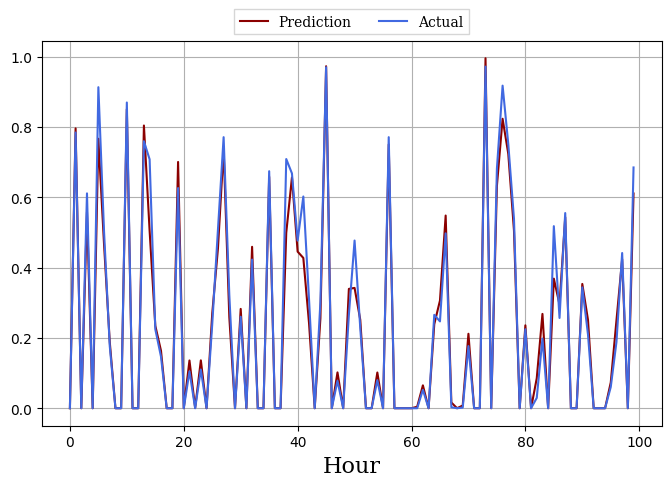

In [28]:
pred = model.predict(X_test[0:100])
actual = np.array(y_test[0:100])
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
ax1.plot(pred, color = 'darkred', label = 'Prediction')
ax1.plot(actual, color = 'royalblue', label = 'Actual')
ax1.set_xlabel('Hour', fontsize=16, fontstyle='normal', family = 'serif')
ax1.set_ylabel('', fontsize=16, fontstyle='normal', family = 'serif')
ax1.legend(loc='upper center',  bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=2, fontsize=20, prop={'family': 'serif'})
# ax1.set_xticks(ind, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'))
# ax1.set_yticks(np.arange(0, 100,20))
plt.grid()